#TASK 1

1.   PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. Use the `torchvision.datasets` to import preloaded Dataset [`CIFAR`](https://pytorch.org/vision/stable/datasets.html#cifar) to train and then finetune the ResNet18 model.

In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import optim
from torchvision import models
from torchvision import transforms
from torchsummary import summary
from torch.utils.data.dataloader import DataLoader

In [2]:
#Loading in Resnet18 pre-trained Model

model = models.resnet18(pretrained=True)

#You can use ```dir(models)``` to see various models available for Transfer Learning

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [3]:
#Freeze the model weights
for param in model.parameters():
    param.requires_grad = False

In [4]:
#Add the fully connected layer
#Here replace num_classes with number of classes you are classifying 

model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model.fc = nn.Linear(512, 10)
model.to(device="cuda")

#Check model summary once to ensure the changes you made

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
summary(model, input_size=(3, 32, 32), batch_size=500)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [500, 64, 32, 32]           1,728
       BatchNorm2d-2          [500, 64, 32, 32]             128
              ReLU-3          [500, 64, 32, 32]               0
         MaxPool2d-4          [500, 64, 16, 16]               0
            Conv2d-5          [500, 64, 16, 16]          36,864
       BatchNorm2d-6          [500, 64, 16, 16]             128
              ReLU-7          [500, 64, 16, 16]               0
            Conv2d-8          [500, 64, 16, 16]          36,864
       BatchNorm2d-9          [500, 64, 16, 16]             128
             ReLU-10          [500, 64, 16, 16]               0
       BasicBlock-11          [500, 64, 16, 16]               0
           Conv2d-12          [500, 64, 16, 16]          36,864
      BatchNorm2d-13          [500, 64, 16, 16]             128
             ReLU-14          [500, 64,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [6]:
#Define your transformations to be applied on the images here

train = transforms.Compose([
    transforms.RandomApply(transforms=[transforms.Pad(2, padding_mode='symmetric'),
                                       transforms.RandomAffine(degrees=10, translate=(0.05,0.05), scale=(0.8,1))],
                           p=0.3),
    transforms.RandomResizedCrop(32, scale=(0.8, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomPosterize(3, p=0.2),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomGrayscale(p=0.1,),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
#Import the CIFAR apply the transformations you created above
#You can access the link given in question statement to check syntax for importing the dataset

train_data = torchvision.datasets.CIFAR10(root="./datasets", train=True, transform=train, download=True)
val_data = torchvision.datasets.CIFAR10(root="./datasets", train=False, transform=val, download=True)

#Remember to split the dataset into train_dataset and val_dataset


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified


In [8]:
#Create DataLoaders for you train and val Datasets
train_dl = DataLoader(train_data, batch_size = 500, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_data, batch_size = 500, num_workers = 2, pin_memory = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1 => automobile


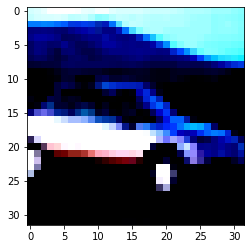

In [9]:
'''print(your_dataset_name.classes[label])
to check the label of the images imported'''

img, label = train_data[4]
plt.imshow(img.permute(1, 2, 0))
print("label:", label, "=>", train_data.classes[label])

In [10]:
'''Define your train function here
you may exclude the timer and scheduler'''

def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name="best.pt",
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    
    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf
    valid_max_acc = 0

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')
    
    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        
        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Get model outputs and calculate loss
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

        # After training loops ends, start validation
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    
                    return model

    # Attach the optimizer
    model.optimizer = optimizer
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    return model


In [11]:
'''define the criterion,optimizer and scheduler(if used) parameters here'''

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
'''run the model'''

model = train(
    model,
    criterion,
    optimizer,
    train_dl,
    val_dl,
    save_file_name="best.pt",
    max_epochs_stop=5,
    n_epochs=30,
    print_every=1
)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 2.0918 	Validation Loss: 1.8283
		Training Accuracy: 25.05%	 Validation Accuracy: 34.83%

Epoch: 1 	Training Loss: 1.8510 	Validation Loss: 1.7136
		Training Accuracy: 34.16%	 Validation Accuracy: 39.64%

Epoch: 2 	Training Loss: 1.7744 	Validation Loss: 1.6600
		Training Accuracy: 36.66%	 Validation Accuracy: 40.90%

Epoch: 3 	Training Loss: 1.7357 	Validation Loss: 1.5971
		Training Accuracy: 38.64%	 Validation Accuracy: 43.32%

Epoch: 4 	Training Loss: 1.6913 	Validation Loss: 1.5578
		Training Accuracy: 40.24%	 Validation Accuracy: 45.39%

Epoch: 5 	Training Loss: 1.6663 	Validation Loss: 1.5230
		Training Accuracy: 41.18%	 Validation Accuracy: 47.16%

Epoch: 6 	Training Loss: 1.6287 	Validation Loss: 1.4810
		Training Accuracy: 42.42%	 Validation Accuracy: 49.02%

Epoch: 7 	Training Loss: 1.6025 	Validation Loss: 1.4468
		Training Accuracy: 43.64%	 Validation Accuracy: 49.87%

Epoch: 8 	Training Loss: 1.5717 	Validation Lo

In [13]:
'''Unfreeze all the layers and finetune the model to increase accuracy as model gets updated for relevancy towards the dataset'''

for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=0.0001)

model = train(
    model,
    criterion,
    optimizer,
    train_dl,
    val_dl,
    save_file_name="best.pt",
    max_epochs_stop=5,
    n_epochs=30,
    print_every=1
)

Model has been trained for: 30 epochs.


Epoch: 0 	Training Loss: 0.8573 	Validation Loss: 0.5426
		Training Accuracy: 69.97%	 Validation Accuracy: 81.58%

Epoch: 1 	Training Loss: 0.5852 	Validation Loss: 0.4331
		Training Accuracy: 79.51%	 Validation Accuracy: 85.28%

Epoch: 2 	Training Loss: 0.4847 	Validation Loss: 0.3809
		Training Accuracy: 83.14%	 Validation Accuracy: 87.35%

Epoch: 3 	Training Loss: 0.4142 	Validation Loss: 0.3472
		Training Accuracy: 85.38%	 Validation Accuracy: 88.21%

Epoch: 4 	Training Loss: 0.3735 	Validation Loss: 0.3344
		Training Accuracy: 86.82%	 Validation Accuracy: 88.66%

Epoch: 5 	Training Loss: 0.3379 	Validation Loss: 0.3082
		Training Accuracy: 88.17%	 Validation Accuracy: 89.82%

Epoch: 6 	Training Loss: 0.3083 	Validation Loss: 0.3011
		Training Accuracy: 89.21%	 Validation Accuracy: 89.80%

Epoch: 7 	Training Loss: 0.2835 	Validation Loss: 0.3074
		Training Accuracy: 90.09%	 Validation Accuracy: 89.95%

Epoch: 8 	Training Loss: 0.2604 	Valida

#TASK 2

In [14]:
import numpy as np
import pandas as pd
import random
import ast
import cv2

from google.colab.patches import cv2_imshow

In [15]:
# Load the datasets
# reading CSV file
data_iou = pd.read_csv("https://raw.githubusercontent.com/AdityaDas-IITM/SummerSchool-CV-Implementation-2021/main/Dataset%20for%20IOU%20%26%20NMS%20implementation/iou_testcases.csv")
data_iou

,Test_case_number,Box_1,Box_2
0,Test_case_1,"[199, 422, 477, 474]","[31, 419, 204, 436]"
1,Test_case_2,"[345, 367, 449, 502]","[335, 333, 374, 452]"
2,Test_case_3,"[350, 147, 492, 20]","[462, 157, 478, 357]"
3,Test_case_4,"[215, 251, 446, 425]","[126, 463, 360, 510]"


In [16]:
# Load the datasets
# reading CSV file
data_nms = pd.read_csv("https://raw.githubusercontent.com/AdityaDas-IITM/SummerSchool-CV-Implementation-2021/main/Dataset%20for%20IOU%20%26%20NMS%20implementation/nms_testcases.csv")
data_nms

,Test_case_number,Box_1,Box_2,Box_3,Box_4
0,Test_case_1,"[200, 100, 300, 300, 0.95]","[220, 110, 320, 310, 0.85]","[180, 90, 280, 290, 0.85]","[210, 120, 310, 320, 0.65]"
1,Test_case_2,"[200, 100, 400, 200, 0.65]","[220, 110, 420, 210, 0.85]","[180, 90, 380, 190, 0.5]","[210, 120, 410, 220, 0.6]"
2,Test_case_3,"[100, 150, 330, 290, 0.68]","[90, 175, 320, 310, 0.9]","[350, 90, 450, 290, 0.85]","[340, 110, 440, 310, 0.75]"
3,Test_case_4,"[100, 100, 200, 300, 0.95]","[150, 110, 250, 310, 0.85]","[200, 90, 300, 290, 0.85]","[250, 120, 350, 320, 0.63]"


In [17]:
# Convert the pandas dataframe into lists
listOfdata = data_iou.to_numpy().tolist()

#Create list of bounding box coordinates for each of the test cases:
iou_test_case_1 = [ast.literal_eval(listOfdata[0][1]), ast.literal_eval(listOfdata[0][2])]
iou_test_case_2 = [ast.literal_eval(listOfdata[1][1]), ast.literal_eval(listOfdata[1][2])]
iou_test_case_3 = [ast.literal_eval(listOfdata[2][1]), ast.literal_eval(listOfdata[2][2])]
iou_test_case_4 = [ast.literal_eval(listOfdata[3][1]), ast.literal_eval(listOfdata[3][2])]

In [18]:
# Convert the pandas dataframe into lists
listOfDFRows = data_nms.to_numpy().tolist()

#Create list of bounding box coordinates for each of the test cases:
nms_test_case_1 = [ast.literal_eval(listOfDFRows[0][1]), ast.literal_eval(listOfDFRows[0][2]), ast.literal_eval(listOfDFRows[0][3]), ast.literal_eval(listOfDFRows[0][4])]
nms_test_case_2 = [ast.literal_eval(listOfDFRows[1][1]), ast.literal_eval(listOfDFRows[1][2]), ast.literal_eval(listOfDFRows[1][3]), ast.literal_eval(listOfDFRows[1][4])]
nms_test_case_3 = [ast.literal_eval(listOfDFRows[2][1]), ast.literal_eval(listOfDFRows[2][2]), ast.literal_eval(listOfDFRows[2][3]), ast.literal_eval(listOfDFRows[2][4])]
nms_test_case_4 = [ast.literal_eval(listOfDFRows[3][1]), ast.literal_eval(listOfDFRows[3][2]), ast.literal_eval(listOfDFRows[3][3]), ast.literal_eval(listOfDFRows[3][4])]

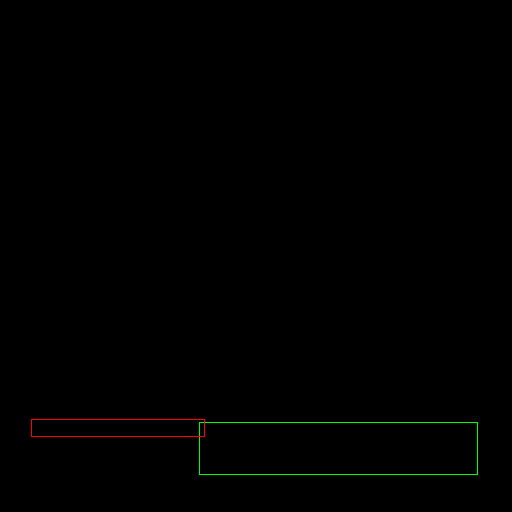

In [19]:
# Visualize the boxes for one of the test cases
img = np.zeros([512,512,3], dtype = np.uint8)
box1, box2= iou_test_case_1[0], iou_test_case_1[1]
cv2.rectangle(img, (box1[0], box1[1]), (box1[2], box1[3]), color = (0,255,0))#green
cv2.rectangle(img, (box2[0], box2[1]), (box2[2], box2[3]), color = (0,0,255))#red

cv2_imshow(img)

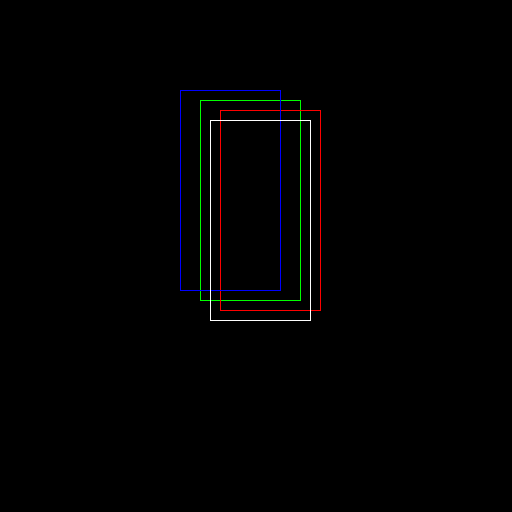

In [20]:
# Visualize the boxes for one of the test cases
img = np.zeros([512,512,3] ,dtype = np.uint8)
box1, box2, box3, box4 = nms_test_case_1[0], nms_test_case_1[1], nms_test_case_1[2], nms_test_case_1[3]
cv2.rectangle(img, (box1[0], box1[1]), (box1[2], box1[3]), color = (0,255,0))
cv2.rectangle(img, (box2[0], box2[1]), (box2[2], box2[3]), color = (0,0,255))
cv2.rectangle(img, (box3[0], box3[1]), (box3[2], box3[3]), color = (255,0,0))
cv2.rectangle(img, (box4[0], box4[1]), (box4[2], box4[3]), color = (255,255,255)) 

cv2_imshow(img)

In [21]:
'''
Exercise: Implement iou(). Some hints:
    In this exercise only, we define a box using its two corners (upper left and
     lower right): (x1, y1, x2, y2) rather than the midpoint and height/width.
    To calculate the area of a rectangle you need to multiply its height 
    (y2 - y1) by its width (x2 - x1)
    You'll also need to find the coordinates (xi1, yi1, xi2, yi2) of the 
    intersection of two boxes. 
'''
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """
################################################################################
# TODO: Replace "None" with the correct code/ logic to find IoU for the boxes. #
# Remember to account for the case in which IoU is 0.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1   #
    # and box2. Calculate its Area.                                            #
    xi1 = box1[0] if box2[0] <= box1[0] <= box2[2] else box2[0] if box1[0] <= box2[0] <= box1[2] else None
    yi1 = box1[1] if box2[1] <= box1[1] <= box2[3] else box2[1] if box1[1] <= box2[1] <= box1[3] else None
    xi2 = box1[2] if box2[0] <= box1[2] <= box2[2] else box2[2] if box1[0] <= box2[2] <= box1[2] else None
    yi2 = box1[3] if box2[1] <= box1[3] <= box2[3] else box2[3] if box1[1] <= box2[3] <= box1[3] else None
    # Case in which they don't intersec --> max(,0)
    inter_area = (0 if xi1 is None or yi1 is None or xi2 is None or yi2 is None
                  else (xi2 - xi1) * (yi2 - yi1))

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

    # compute the IoU
    iou = inter_area / union_area
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    return iou

In [22]:
################################################################################
# TODO: Replace "None" with the correct code/ logic to find IoU for the boxes. #
# Perform iou on the test cases                                                #
################################################################################
iou_result_1 = iou(iou_test_case_1[0], iou_test_case_1[1])
iou_result_2 = iou(iou_test_case_2[0], iou_test_case_2[1])
iou_result_3 = iou(iou_test_case_3[0], iou_test_case_3[1])
iou_result_4 = iou(iou_test_case_4[0], iou_test_case_4[1])
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [23]:
# Print out the test cases:
print("IoU for 1st test case is:", iou_result_1, 
      "\nIoU for 2nd test case is:", iou_result_2, 
      "\nIoU for 3rd test case is:", iou_result_3, 
      "\nIoU for 4th test case is:", iou_result_4)

IoU for 1st test case is: 0.004039937669533099 
IoU for 2nd test case is: 0.15201036013813518 
IoU for 3rd test case is: -0.0 
IoU for 4th test case is: 0.0


In [24]:
'''
Exercise: Implement nms(). Some hints:
    In this function, we will be performing non max suppression to select 
    bounding boxes for an object.
    We will be assuming there is only one class of objects. However, the code is
    is not very different for multiple classes of objects. 
    
    c_score represents the confidence score of particular bounding box.

    Use the iou function defined earlier.

    Remember the algorithm to perform nms:
    Discard all bounding boxes with confidence score < c_score_threshold
    While there are any remaining boxes:
      Pick box with largest confidence, output that as prediction.
      Discard any remaining boxes with IoU > iou_threshold with the output box. 

    0.6 is an arbitrary number- feel free to experiment with it.

    Make use of list comprehenion
'''
def nms(bboxes,iou_threshold,c_score_threshold):
  '''
    Implement non max supression given a list of bounding boxes.
    Arguments:
    bboxes: list of lists- the inner lists contain 5 elements and are of the
            following format: [x1, y1, x2, y2, c_score]
    iou_threshold: The threshold above which bounding boxes with lower confidence
                    score are removed.
    c_score_threshold: The minimum value of c_score below which bounding boxes
                       are removed.
    ''' 
################################################################################
# TODO: Replace "None" with the correct code/ logic to find IoU for the boxes. #
# Remember to account for the case in which IoU is 0.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

  #Using list comprehension (or otherwise), select bounding boxes which have
  # confidence score greater than c_score_threshold.
  bboxes = [bbox for bbox in bboxes if bbox[4] >= c_score_threshold]

  #Sort the bounding boxes in decreasing order of confidence score.
  bboxes = sorted(bboxes, key=lambda bbox: -bbox[4]) # [:,:,-1]

  #An empty list to store selected bounding boxes.
  boxes_after_nms = []

  #Loop through the bounding boxes
  while bboxes:
      #Select box with highest confidence score
      chosen_box = bboxes[0]
      #Using list comprehension (or otherwise), eliminate bounding boxes whose
      #iou with "chosen_box" is greater than threshold.
      bboxes = [bbox for bbox in bboxes[1:] if iou(bbox, chosen_box) < iou_threshold]
      #Add the bbox with highest confidence score to the formerly created list.
      boxes_after_nms.append(chosen_box)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
  return boxes_after_nms

In [25]:
################################################################################
# TODO: Replace "None" with the correct code/ logic to find nms for the boxes. #
# Perform nms on the test cases 
# Experiment with values for iou threshold and c_score threshold               #
################################################################################
nms_result_1 = nms(nms_test_case_1, 0.2, 0.6)
nms_result_2 = nms(nms_test_case_2, 0.2, 0.6)
nms_result_3 = nms(nms_test_case_3, 0.2, 0.6)
nms_result_4 = nms(nms_test_case_4, 0.2, 0.6)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [26]:
# Check the number of bounding boxes returned for eaach test case.
print("Number of bounding boxes returned for 1st test case is: ", len(nms_result_1),
      "\nNumber of bounding boxes returned for 2nd test case is: ", len(nms_result_2),
      "\nNumber of bounding boxes returned for 3rd test case is: ", len(nms_result_3),
      "\nNumber of bounding boxes returned for 4th test case is: ", len(nms_result_4))

Number of bounding boxes returned for 1st test case is:  1 
Number of bounding boxes returned for 2nd test case is:  1 
Number of bounding boxes returned for 3rd test case is:  2 
Number of bounding boxes returned for 4th test case is:  2


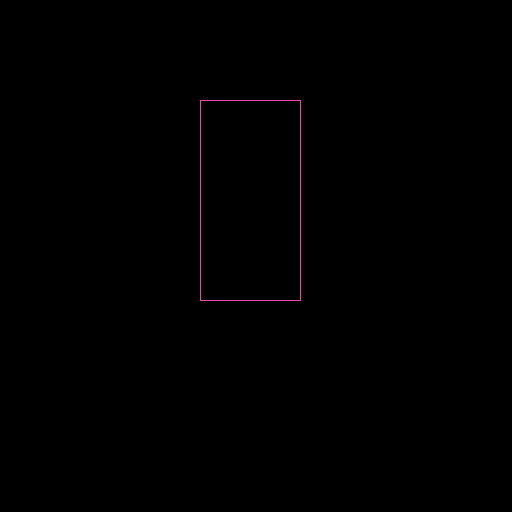

In [27]:
# Depending on the number of bounding boxes, visualize the results. 
img = np.zeros([512,512,3], dtype = np.uint8)

box = nms_result_1
for i in range(len(nms_result_1)):
    color = tuple(np.random.random(size=3) * 256)
    cv2.rectangle(img, (box[i][0], box[i][1]), (box[i][2], box[i][3]), color)

cv2_imshow(img)

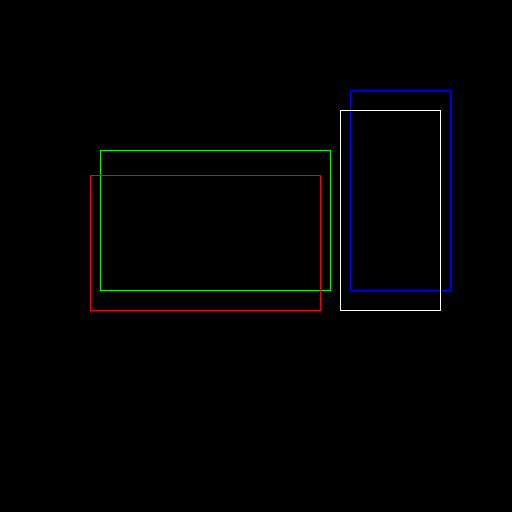

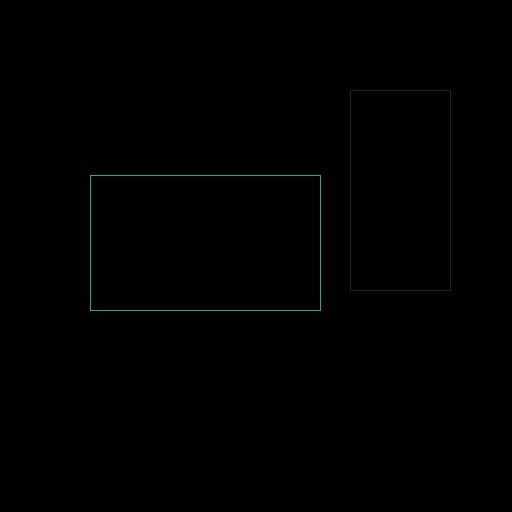

In [28]:
img = np.zeros([512,512,3] ,dtype = np.uint8)
box1, box2, box3, box4 = nms_test_case_3[0], nms_test_case_3[1], nms_test_case_3[2], nms_test_case_3[3]
cv2.rectangle(img, (box1[0], box1[1]), (box1[2], box1[3]), color = (0,255,0))
cv2.rectangle(img, (box2[0], box2[1]), (box2[2], box2[3]), color = (0,0,255))
cv2.rectangle(img, (box3[0], box3[1]), (box3[2], box3[3]), color = (255,0,0))
cv2.rectangle(img, (box4[0], box4[1]), (box4[2], box4[3]), color = (255,255,255)) 
cv2_imshow(img)

img2 = np.zeros([512,512,3] ,dtype = np.uint8)
box = nms_result_3
for i in range(len(nms_result_3)):
    color = tuple(np.random.random(size=3) * 256)
    cv2.rectangle(img2, (box[i][0], box[i][1]), (box[i][2], box[i][3]), color)

cv2_imshow(img2)